In [1]:
from examples_helper_functions import *

# Sparsifier class

All of the classes in sparsekmeans are subclasses of the base class `Sparsifier`, which contains all of the methods necessary for data transformation and dimensionality reduction. The main purpose of the `Sparsifier` class is to apply the Random Orthogonal System (ROS) preconditioning and subsampling to the dense data. 

## Basic Usage

In [2]:
# generate some random data
number_of_datapoints = 1000
latent_dimension = 800
X = np.random.rand(number_of_datapoints, latent_dimension)

# sparsify it
from sparseklearn import Sparsifier
spf = Sparsifier(gamma=0.05)
spf.fit_sparsifier(X)

print("Data reduced from {} to {} dimensions.".format(spf.P, spf.M))

Data reduced from 800 to 40 dimensions.


## Conceptual Discussion

### Shared subsampling ratio $\alpha$

In the following we will look at how the `Sparsifier` subsamples an array of integers. There are 6 datapoints (rows) and each datapoint lives in $\mathbb{R}^5$ (columns). We fit the sparsifier to this data keeping 2 entries from each datapoint. We ask for a dense sparsity format so that we can look at the array and visually identify which entries have been subsampled. Since the original $X$ doesn't have any zeros in it, we know that the zero entries below correspond to the entries of each datapoint that were not kept by the subsampling. 

In [21]:
np.random.seed(12)
number_of_datapoints = 6
latent_dimension = 5
X = np.random.randint(1,5,size=(number_of_datapoints, latent_dimension))
spf = Sparsifier(gamma = 2, sparsity_format = 'dense', use_ROS = False)
spf.fit_sparsifier(X)
spf.HDX_sub.astype(int)

array([[0, 0, 0, 2, 2],
       [0, 4, 0, 0, 1],
       [3, 2, 0, 0, 0],
       [0, 3, 0, 3, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 4, 3, 0]])

Each row has two non-zero entries which were chosen uniformly at random. Notice that rows 0 and 2 don't have any columns in common.

In [4]:
spf.HDX_sub[[0,2]].astype(int)

array([[0, 0, 0, 2, 2],
       [3, 2, 0, 0, 0]])

Supposed we want to compute the distance between these datapoints. The exact distance $\lVert \mathbf{x}_0 - \mathbf{x}_2 \rVert_2$ is 3, but the masked distance $\lVert \mathbf{x}_0 - \mathbf{x}_2 \rVert_S$ is 0:

In [22]:
print('Euclid = {}'.format(np.linalg.norm(X[0]-X[2])))
print('Masked = {}'.format(spf.pairwise_distances(X,X,mask = spf.mask, transform_X = 'R', transform_Y = 'R')[0,2]))

Euclid = 3.0
Masked = 0.0


This happens because $\mathbf{x}_0$ and $\mathbf{x}_2$ don't share any subsampled dimensions. The masked distance between them is **not** computed by $\lVert R_0^T \mathbf{x}_0 - R_2^T\mathbf{x}_2 \rVert_2$, but rather as the **need to come up with notation for this**. When datapoints don't share any subsampled dimenions, then, they cannot communicate with each other in the subsampled domain. There are times when it is desirable to make sure this never happens; in particular, we want to watch out for cases of extreme subsampling ($\gamma \ll 1$), in which case it's conceivable that $\lVert \mathbf{x} - \mathbf{y} \rVert_S = 0$ for any $\mathbf{x},\mathbf{y} \in {X}$. To prevent this we can force the subsampling algorithm to keep some shared entries. If we know that we are keeping $m$ entries from each datapoint, we can require that some $m_\alpha$ of these be common between all datapoints. The `Sparsifier` does this with the parameter `alpha`, which can be an integer in $\{0,1,\ldots,m\}$ or a float in $(0,1]$. If it's an integer, the `Sparsifier` will force that many shared columns, and if it's a float then `Sparsifier` will force $m_\alpha$ shared columns (the biggest integer so that the fraction of shared columns is below $\alpha$). The remaninng $m-m_\alpha$ entries are chosen uniformly at random for each datapoint, so that we may end up with strictly more than $m_\alpha$ shared entries. Let's fit the sparsifier again to the same data, but set `alpha=1` so that we are guaranteed at least one shared column. 

In [19]:
spf2 = Sparsifier(gamma = 2, alpha = 1, sparsity_format = 'dense', use_ROS = False)
spf2.fit_sparsifier(X)
spf2.HDX_sub.astype(int)

array([[0, 0, 3, 2, 0],
       [0, 0, 4, 1, 0],
       [3, 0, 1, 0, 0],
       [2, 0, 4, 0, 0],
       [0, 0, 1, 0, 2],
       [0, 0, 4, 0, 1]])

Now the subsampled data share the second column, and each also has one other column chosen uniformly at random from the remaining columns. The masked distance is no longer 0:

In [20]:
print('Euclid = {}'.format(np.linalg.norm(X[0]-X[2])))
print('Masked = {}'.format(spf2.pairwise_distances(X,X,mask = spf.mask, transform_X = 'R', transform_Y = 'R')[0,2]))

Euclid = 3.0
Masked = 2.0


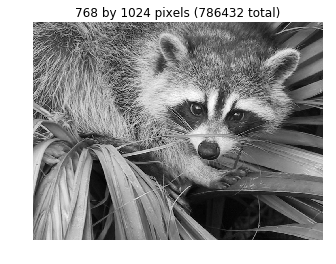

In [8]:
plt.imshow(face,cmap = plt.cm.gray)
plt.title('{} by {} pixels ({} total)'.format(fR,fC,fR*fC))
plt.axis('off')
plt.show()

The `Sparsifier` class works on 2D arrays of data, in which each row is a datapoint. The image above then must be reshaped to a 1 by 786432. In practice, of course, we'd have many more datapoints. First we'll just randomly subsample pixels, keeping 30% of them (`ex1`). Then we'll precondition the original image with an ROS transform, and then subsample 30% of the pixels again (`ex2`).

In [ ]:
# subsample without preprocessing
ex1 = Sparsifier(gamma = 0.3, dense_subsample = True, use_ROS = False)
ex1.fit_sparsifier(flatface)

# subsample with preprocessing
ex2 = Sparsifier(gamma = 0.3, dense_subsample = True, use_ROS = True)
ex2.fit_sparsifier(flatface)

In `ex1` we didn't apply the ROS, but since we did in `ex2`, we need to invert it to recover the data in the original space. We've set the flag `dense_subsample` in the examples above; this makes it so that `HDX_sub` is the same shape as `X`, which means it's a dense representation of a sparse matrix. This is inefficient but necessary for our illustrative purposes here. Below we plot all 3 images as negatives to better show the sparsity patterns.

In [ ]:
# flatface1 is the subsampled flattened image
flatface1 = ex1.HDX_sub
# flatface2 is the subsampled preconditioned image, 
flatface2 = ex2.invert_ROS(ex2.HDX_sub, ex2.D_indices)
faces = [flatface, flatface1, flatface2]

In [ ]:
f, (ax0, ax1, ax2) = plt.subplots(figsize=(20,62),ncols=3)
title = ['original image', r'$\gamma = .3$, not preconditioned', r'$\gamma = 0.3$, preconditioned']
axeslist = [ax0,ax1,ax2]
for i in range(3):
    ax = axeslist[i]
    ax.set_title(title[i])
    ax.imshow(faces[i].reshape(fR,fC),cmap='Greys')
    ax.axis('off')
plt.show()

# KMeans clustering

## Basic Usage

Let's import a small sample dataset `/examples/sample_mnist.h5py`. This is a subset of the [mnist dataset](http://yann.lecun.com/exdb/mnist/), consisting of images of hand-drawn integers. In this case, we only have images of 0's, 3's, and 9's. The training set has 1500 images (500 of each integer), and the test set has 300 images (100 of each integer). Each image has been flattened into a vector of length 784, so that the training data are stored as 1500 by 784 array, and the test data as a 300 by 784 array. The labels are loaded as 1D arrays.

In [23]:
from examples_helper_functions import *
from sparseklearn import load_mnist_dataset
np.random.seed(27)
X_train, y_train, X_test, y_test = load_mnist_dataset()

First let's just fit the training data with all the default options. The only parameters we need to specify are the compression factor (gamma) and the number of clusters. Here's what the means look like for the given training data.

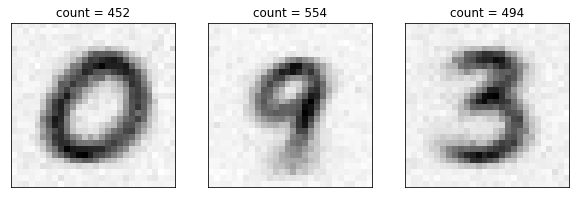

In [24]:
from sparseklearn import KMeans
kmc = KMeans(gamma = 0.1, n_clusters = 3)
kmc.fit(X_train)

plot_mnist_means(kmc)

## 1-pass and 2-pass Algorithms

One of the motivations to use `sparseklearn` is that the preceding algorithm is 1-pass, which means that the original data only needs to be seen once at the beginning (and the algorithm is thus suitable for streaming data). If we want to, once the algorithm has found the cluster centers, we can go back over the original (dense) data for a second pass to reconstruct the means. The second pass is computationally cheap - all the hard work is still done on the reduced dataset. 

In [ ]:
kmc.cluster_centers_ = kmc.reconstruct_cluster_centers(n_passes = 2)
plot_mnist_means(kmc)

In the preceding we kept the original fit and recomputed the means from the resulting labels using `reconstruct_cluster_centers`. We could also have passed the parameter `n_passes = 2` when we instantiated the `KMeans` object. 

In [ ]:
kmc = KMeans(gamma = 12, alpha = 3, n_init = 50, n_clusters = 3, n_passes = 2)
kmc.fit(X_train)